<figure>
  <IMG SRC="https://raw.githubusercontent.com/fmeer/public-files/main/TUlogo.png" WIDTH=150 ALIGN="right">
</figure>

# **CEGM2003 project: Bayesian optimization for truss structures**
    
In this notebook, the finite element code `pyJive` is applied to frequency analysis of a truss structure. Specifically, the `ModeShapeModule` is used to compute the natural frequencies of a 37-bar truss bridge structure. The case has been investigated in literature with multiple optimization algorithms, see [Kanarachos et al., 2017](https://dx.doi.org/10.1016/j.compstruc.2016.11.005) for a description of the case and a comparison of the performance of diffferent optimization methods. 
    
Below, the truss is first analyzed with the default settings and then with the optimal parameters from Kanarachos. The notebook demonstrates how to run the finite element program and how to change those inputs that define the design space for the optimization problem. 

In [ ]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm
from scipy.optimize import minimize
import sys
import pandas as pd
import contextlib
from contextlib import redirect_stdout
import io


sys.path.append(r'..\TRUSS1\pyJive')
sys.path.append(r'C:\Users\javie\OneDrive - Delft University of Technology\Year 2\Q2\CEGM2003 - Data Science and Artificial Inteligence for engineers\!Content\Unit 0 - Project\TRUSS1\pyJive')

from utils import proputils as pu
import main
from names import GlobNames as gn

# Read the input file and store in props object
props = pu.parse_file('bridge_frequency.pro')

# Call the program and store output in globdat
globdat = main.jive(props)

## Starting design

The analysis is based on two input files. The main input file, `bridge_frequency.pro` contains all input parameters and other settings of the analysis. It also refers to a second file `bridge.geom`, which defines the geometry and mesh. The initial input matches the starting point of the optimization procedure following Kanarachos. 

Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file bridge.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  5.5961e+01 rad / s


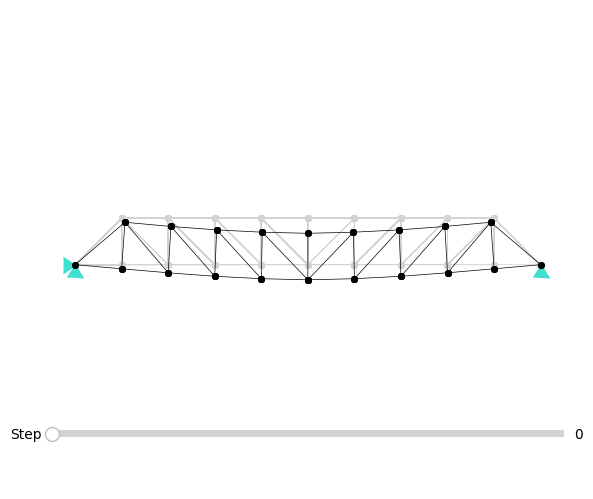

End of execution
Smallest three natural frequencies:  [ 8.90649126 29.59101061 50.01221715]  Hz


In [2]:
# Read the input file and store in props object
props = pu.parse_file('bridge_frequency.pro')

# Call the program and store output in globdat
globdat = main.jive(props)

# Write additional output
print('Smallest three natural frequencies: ', globdat[gn.EIGENFREQS][0:3]/2/np.pi, ' Hz')

### Optimal design from Kanarachos

Now, two changes are made to the problem settings to make the analysis match the optimum solution of Kanarachos. The `props` object, which contains the information from `bridge.pro` in the form of a nested `dict` is overwritten at two of its entries.
- **Cross sectional areas:** these are defined in `props['model']['truss']['area']`
- **Truss geometry:** for this a separate `.geom` file has already been prepared and the program is told to use this one by overwriting the entry `props['init']['mesh']['file']`. Check the differences between the two `.geom`-files in this folder to see how the geometry is updated.

In [1]:
areas = [ 40e-4, 3.1997e-4, 1.0025e-4, 1.0000e-4, 2.5875e-4, 1.0895e-4, 1.1261e-4, 2.5624e-4, 1.4121e-4, 1.5758e-4, 2.2461e-4, 1.0694e-4, 1.3193e-4, 2.3846e-4, 1.0001e-4 ]

In [2]:
len(areas)


15

Initializing module chain...
InitModule: Creating DofSpace...
InitModule: Reading geo mesh file bridge_kanarachos.geom ...
InitModule: Creating node groups...
InitModule: Created group bl with nodes [0]
InitModule: Created group br with nodes [19]
InitModule: Created group bm with nodes [9]
InitModule: Created group bottom with nodes [ 0  1  3  5  7  9 11 13 15 17 19]
InitModule: Creating model...
Creating Line2Shape...
mass  using all doftypes by default:  dict_keys(['dx', 'dy'])
Running chain...
ModeShapeModule: running eigenvalue problem...
ModeShapeModule: smallest natural frequency  1.2608e+02 rad / s


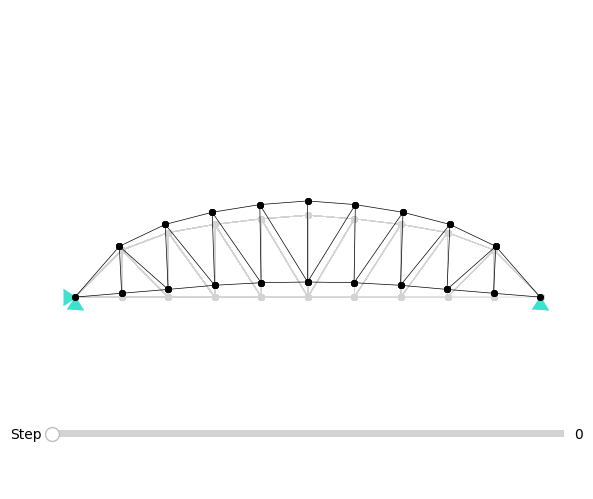

End of execution
Smallest three natural frequencies:  [20.06682059 40.53905183 61.8225322 ]  Hz


In [3]:
# Overwrite relevant inputs
props['model']['truss']['area'] = [ 40e-4, 3.1997e-4, 1.0025e-4, 1.0000e-4, 2.5875e-4, 1.0895e-4, 1.1261e-4, 2.5624e-4, 1.4121e-4, 1.5758e-4, 2.2461e-4, 1.0694e-4, 1.3193e-4, 2.3846e-4, 1.0001e-4 ]
props['init']['mesh']['file'] = 'bridge_kanarachos.geom'

# Call program with updated inputs
globdat = main.jive(props)
print('Smallest three natural frequencies: ', globdat[gn.EIGENFREQS][0:3]/2/np.pi, ' Hz')

## Definitions

In [1]:
class BayesianOptimizer():
      
    def __init__(self, target_func, x_init, y_init, n_iter, scale, batch_size):
        self.x_init = x_init
        self.y_init = y_init
        self.target_func = target_func
        self.n_iter = n_iter
        self.scale = scale
        self.batch_size = batch_size
        self.gauss_pr = GaussianProcessRegressor()
        self.best_samples_ = pd.DataFrame(columns = ['x', 'y', 'ei'])
        self.distances_ = []

    def _get_expected_improvement(self, x_new):

        # Using estimate from Gaussian surrogate instead of actual function for 
        # a new trial data point to avoid cost 
        print(x_new.shape)
        mean_y_new, sigma_y_new = self.gauss_pr.predict(np.array([x_new]), return_std=True)
        sigma_y_new = sigma_y_new.reshape(-1,1)
        print(sigma_y_new, mean_y_new)
        if sigma_y_new[-1] == 0.0:
            return 0.0
        
        # Using estimates from Gaussian surrogate instead of actual function for 
        # entire prior distribution to avoid cost
        mean_y = self.gauss_pr.predict(self.x_init)
        max_mean_y = np.max(mean_y)
        z = (mean_y_new - max_mean_y) / sigma_y_new
        exp_imp = (mean_y_new - max_mean_y) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        print("exp_imp shape:", exp_imp.shape)
        return exp_imp
    
    def _acquisition_function(self, x):
        return self._get_expected_improvement(x)
    ############ LOOk AT###
    def _get_next_probable_point(self):
            min_ei = float(sys.maxsize)
            x_optimal = None 
            for x_start in (np.random.random((self.batch_size,self.x_init.shape[1])) * self.scale):
                #response = minimize(fun=self._acquisition_function, x0=x_start, method='L-BFGS-B')
                response = minimize(fun=lambda x: self._acquisition_function(x), x0=x_start, method='L-BFGS-B')
    
                print(response.fun)
                if response.fun < min_ei:
                    min_ei = response.fun
                    x_optimal = response.x
                
                return x_optimal, min_ei
            
    def _extend_prior_with_posterior_data(self, x,y):
        self.x_init = np.concatenate((self.x_init, [x]), axis = 0)
        self.y_init = y
        
        # self.x_init = np.append(self.x_init, np.array([x]), axis = 0)
        # self.y_init = np.append(self.y_init, y, axis = 0)
  
    def optimize(self):
        y_max = self.y_init
        optimal_x = self.x_init  # Assuming this is the initial design
        y_next = []

        for i in range(self.n_iter):
            self.gauss_pr.fit(self.x_init[-1].reshape(1,-1), np.array([self.y_init]))  # Fit model with initial data
            x_next, ei = self._get_next_probable_point()  # Propose a new design
            y_next.append(self.target_func(np.array([x_next])))  # Evaluate the new design
            self._extend_prior_with_posterior_data(x_next, y_next)

            # Update if the new design is better
            if y_next[-1] <= y_max:  # Assuming minimization
                y_max = y_next[-1]
                optimal_x = x_next
                optimal_ei = ei
            else:
                optimal_ei = 0
            # Track the distance between consecutive designs, if needed
            if i > 0:
                self.distances_.append(np.linalg.norm(self.x_init[-2] - x_next))

            # Update best samples
            self.best_samples_ = self.best_samples_.append({"y": y_max, "ei": optimal_ei}, ignore_index=True)

        return optimal_x, y_max

In [5]:
class TRUSS:
    def __init__(self, file_path, output_path ,cross_sections,penalty,threshold):
        # ------------------------------ DO NOT CHANGE  ------------------------------ #
        self.file_path = file_path
        self.output_path = output_path
        self.nodes = {} 
        self.connectivity = None

        self.penalty = penalty
        self.threshold = threshold
        # --------------------------------- ATRIBUTES -------------------------------- #
        self.member_df = None
        self.y_coordinates =  None  # Targets or other appropriate initialization
        self.cross_sections = np.array(cross_sections) # 

    def FEMTargetFunction(self,design_variables):
        
        #design_variables = design_variables[0] 
        
        N = len(self.y_coordinates)
        self.y_coordinates = design_variables[-1,:N]
        self.cross_sections = design_variables[-1,N:]


        props['model']['truss']['area'] = self.cross_sections
        geom = self.write_geom_file(self.output_path)
        props['init']['mesh']['file'] = self.output_path
        
        trap = io.StringIO()
        with redirect_stdout(trap):
            globdat = main.jive(props);

        NFreq = globdat[gn.EIGENFREQS][0:3]/2/np.pi 

        # Loop through NFreq and thresholds
        for i in range(len(NFreq)):
            if NFreq[i] < self.threshold[i]:
                NFreq[i] = self.penalty
        
        NFreq = sum(NFreq)/3 # We return the average

        return NFreq
    
    def mmscaler(self, mode, y_coord, cross_sections, scaled_data=None, scaler_y=None, scaler_cs=None):
        """
        Function to scale or descale data.
        
        :param mode: 'scale' for scaling, 'descale' for descaling.
        :param y_coord: Y-coordinates array.
        :param cross_sections: Cross-sections array.
        :param scaled_data: Scaled data for descaling, required if mode is 'descale'.
        :param scaler_y: Scaler for Y-coordinates.
        :param scaler_cs: Scaler for cross sections.
        :return: Scaled or descaled data.
        """
        if mode == 'scale':
            # Initialize scalers if not provided
            # if not scaler_y:
            #     scaler_y = MinMaxScaler()
            # if not scaler_cs:
            #     scaler_cs = MinMaxScaler()

            y_coordinates = y_coord.reshape(-1, 1) 
            cross_sections = cross_sections.reshape(-1, 1)

            scaled_y_coordinates = y_coordinates
            scaled_cross_sections = cross_sections
            # scaled_y_coordinates = scaler_y.fit_transform(y_coordinates)
            # scaled_cross_sections = scaler_cs.fit_transform(cross_sections)
            
            x_values = np.concatenate((scaled_y_coordinates, scaled_cross_sections), axis=0)
            self.y_coordinates = scaled_y_coordinates.flatten()
            self.cross_sections = scaled_cross_sections.flatten()

            return x_values

        elif mode == 'descale':
            if scaled_data is None:
                raise ValueError("Scaled data is required for descaling")
            if not scaler_y or not scaler_cs:
                raise ValueError("Scalers are required for descaling")

            num_y_coordinates = y_coord.size
            scaled_y_coordinates = scaled_data[:, :num_y_coordinates]
            scaled_cross_sections = scaled_data[:, num_y_coordinates:]

            original_y_coordinates = scaler_y.inverse_transform(scaled_y_coordinates)
            original_cross_sections = scaler_cs.inverse_transform(scaled_cross_sections)

            x_values = np.concatenate((original_y_coordinates, original_cross_sections), axis=1)

            return x_values
        
        else:
            raise ValueError("Invalid mode selected. Choose 'scale' or 'descale'.")

    ##
    #self.member_df = self.member_df.drop('Number of Elements', axis=1)
        #self.member_df['Cross Sections'] = None
        # for index, row in self.member_df.iterrows():
        #     cross_section_type = row['Cross-section Type']
        #     self.member_df.at[index, 'Cross Sections'] = self.cross_sections[cross_section_type]
    # ---------------------------------------------------------------------------- #
    #                               WRITING FUNCTIONS                              #
    # ---------------------------------------------------------------------------- #
    def read_geom_file(self):
        with open(self.file_path, 'r') as file:
            lines = file.readlines()

        nodes = {}
        members = []
        section = None

        for line in lines:
            line = line.strip()
            if line.startswith('node:'):
                section = 'node'
                continue
            elif line.startswith('member:'):
                section = 'member'
                continue

            if section == 'node' and line:
                parts = line.split()
                node_number = int(parts[0])
                node_data = tuple(map(float, parts[1:]))
                nodes[node_number] = node_data
            elif section == 'member' and line:
                member_data = tuple(map(int, line.split()))
                members.append(member_data)

        self.nodes = nodes
        self.member_df = pd.DataFrame(members, columns=['Node #1', 'Node #2', 'Number of Elements', 'Cross-section Type'])
        
        self.connectivity = self.member_df.to_numpy()
        self.y_coordinates = np.array([value[1] for key, value in self.nodes.items()])

    def write_geom_file(self, output_file_path):

        for i, (x, _) in self.nodes.items():
            self.nodes[i] = (x, self.y_coordinates[i])

        geom = 'node: node #, x-coordinate; y-coordinate\n'
        for node_num, coords in self.nodes.items():
            geom += f"{node_num} {' '.join(map(str, coords))}\n"
        
        geom += '\nmember: Node #1; Node #2; number of elements; cross-section type\n'
        for row in self.connectivity:
            geom += ' '.join(map(str, row)) + '\n'

        with open(output_file_path, 'w') as file:
            file.write(geom)

        return geom
    

In [7]:
def target_function_wrapper(design_variables):
    return TRUSS1.FEMTargetFunction(design_variables)

## Optimisation 

In [24]:
TRUSS1.connectivity

array([[ 0,  1,  1,  0],
       [ 0,  2,  1,  1],
       [ 1,  2,  1,  2],
       [ 2,  3,  1,  3],
       [ 2,  4,  1,  4],
       [ 3,  4,  1,  5],
       [ 4,  5,  1,  6],
       [ 4,  6,  1,  7],
       [ 5,  6,  1,  8],
       [ 6,  7,  1,  9],
       [ 6,  8,  1, 10],
       [ 7,  8,  1, 11],
       [ 8,  9,  1, 12],
       [ 9, 12,  1, 12],
       [ 8, 10,  1, 13],
       [ 9, 10,  1, 14],
       [10, 12,  1, 13],
       [11, 12,  1, 11],
       [12, 14,  1, 10],
       [11, 14,  1,  9],
       [13, 14,  1,  8],
       [14, 16,  1,  7],
       [13, 16,  1,  6],
       [15, 16,  1,  5],
       [16, 18,  1,  4],
       [15, 18,  1,  3],
       [17, 18,  1,  2],
       [18, 19,  1,  1],
       [ 1,  3,  1,  0],
       [ 3,  5,  1,  0],
       [ 5,  7,  1,  0],
       [ 7,  9,  1,  0],
       [ 9, 11,  1,  0],
       [11, 13,  1,  0],
       [13, 15,  1,  0],
       [15, 17,  1,  0],
       [17, 19,  1,  0]], dtype=int64)

In [35]:
TRUSS1.nodes.values()[:,:]

TypeError: 'dict_values' object is not subscriptable

In [27]:
TRUSS1.y_coordinates.shape
TRUSS1.cross_sections.shape

(15,)

In [ ]:

def calculate_length(node1, node2, coordinates):
    x1, y1 = coordinates[node1]
    x2, y2 = coordinates[node2]
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def mass_truss(areas, y_list, connectivity, density=7800):
    x_coordinates = np.arange(11)

    y_coordinates = np.zeros_like(x_coordinates)
    y_coordinates[1:-1] = y_list

    coordinates = list(zip(x_coordinates, y_coordinates))
    lengths = np.zeros(len(areas))

    for i, (node1, node2) in enumerate(connectivity):
        lengths[i] = calculate_length(node1, node2, coordinates)  # Node indices are 1-based

    volumes = lengths * areas

    total_volume = np.sum(volumes)
    mass = total_volume * density

    return mass

# Example usage
connectivity = TRUSS1.connectivity[:,:2]

areas = np.array(cross_sections)  # Areas should be an array of the cross-sectional areas for each element
y_list = np.array([...])  # y_list should be the y-coordinates of the adjustable nodes

mass = mass_truss(areas, y_list, connectivity)
print("Mass of the truss:", mass)


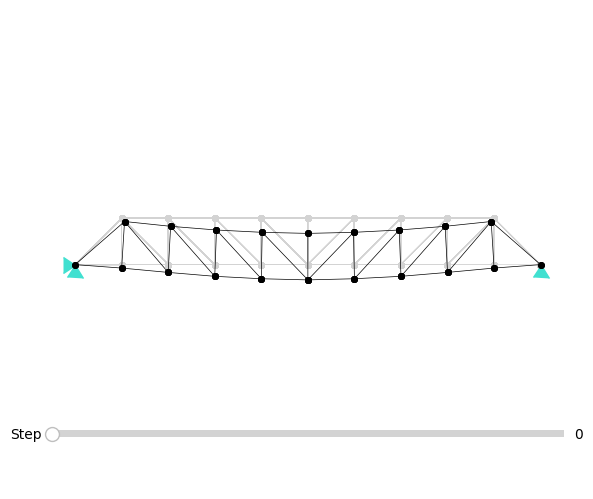

In [6]:
# -------------------------------- DEFINITIONS ------------------------------- #
file_path = r'bridge.geom'
output_path = r'TRUSS1.geom'

cross_sections = [40e-4, 3.1997e-4, 1.0025e-4, 1.0000e-4, 2.5875e-4, 1.0895e-4, 1.1261e-4, 2.5624e-4, 1.4121e-4, 1.5758e-4, 2.2461e-4, 1.0694e-4, 1.3193e-4, 2.3846e-4, 1.0001e-4 ]
freq_thresholds = [20, 40, 60]  # The threshold values for comparison
penalty = 10000
# -------------------------------- PROCESSING -------------------------------- #
TRUSS1 = TRUSS(file_path, output_path ,cross_sections, penalty, freq_thresholds);
TRUSS1.read_geom_file()

x_init = TRUSS1.mmscaler('scale', TRUSS1.y_coordinates, TRUSS1.cross_sections)

TRUSS1.write_geom_file(output_path) #Apply scaling transformations
y_init = TRUSS1.FEMTargetFunction(x_init.T)

(35,)
[[0.999988]] [32.76862659]
exp_imp shape: (1, 1)
(35,)
[[0.999988]] [32.76862654]
exp_imp shape: (1, 1)
(35,)
[[0.999988]] [32.76862628]
exp_imp shape: (1, 1)
(35,)
[[0.999988]] [32.76862674]
exp_imp shape: (1, 1)
(35,)
[[0.999988]] [32.76862633]
exp_imp shape: (1, 1)
(35,)
[[0.999988]] [32.76862688]
exp_imp shape: (1, 1)
(35,)
[[0.999988]] [32.76862643]
exp_imp shape: (1, 1)
(35,)
[[0.999988]] [32.76862666]
exp_imp shape: (1, 1)
(35,)
[[0.999988]] [32.76862639]
exp_imp shape: (1, 1)
(35,)
[[0.999988]] [32.76862672]
exp_imp shape: (1, 1)
(35,)
[[0.999988]] [32.76862657]
exp_imp shape: (1, 1)
(35,)
[[0.999988]] [32.76862669]
exp_imp shape: (1, 1)
(35,)
[[0.999988]] [32.76862641]
exp_imp shape: (1, 1)
(35,)
[[0.999988]] [32.76862675]
exp_imp shape: (1, 1)
(35,)
[[0.999988]] [32.76862646]
exp_imp shape: (1, 1)
(35,)
[[0.999988]] [32.76862691]
exp_imp shape: (1, 1)
(35,)
[[0.999988]] [32.76862632]
exp_imp shape: (1, 1)
(35,)
[[0.999988]] [32.76862664]
exp_imp shape: (1, 1)
(35,)
[[0.

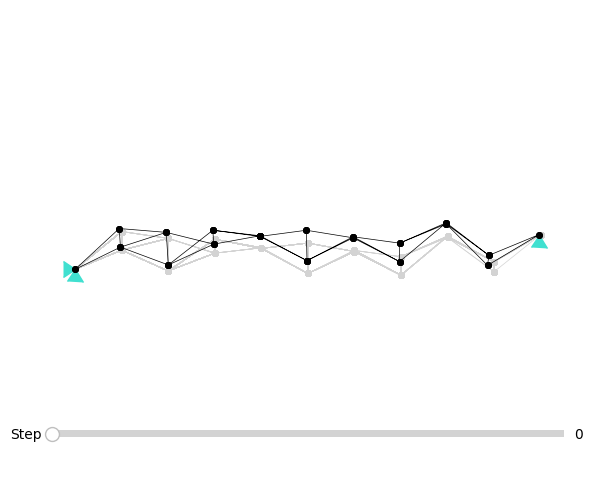

C:\Users\javie\AppData\Local\Temp\ipykernel_15244\3040842390.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.best_samples_ = self.best_samples_.append({"y": y_max, "ei": optimal_ei}, ignore_index=True)


(35,)
[[0.99902629]] [441.18872917]
exp_imp shape: (1, 1)
(35,)
[[0.99902629]] [441.18872731]
exp_imp shape: (1, 1)
(35,)
[[0.99902629]] [441.18872973]
exp_imp shape: (1, 1)
(35,)
[[0.99902629]] [441.18872935]
exp_imp shape: (1, 1)
(35,)
[[0.99902629]] [441.18872852]
exp_imp shape: (1, 1)
(35,)
[[0.99902629]] [441.18872545]
exp_imp shape: (1, 1)
(35,)
[[0.99902629]] [441.188727]
exp_imp shape: (1, 1)
(35,)
[[0.99902629]] [441.18873153]
exp_imp shape: (1, 1)
(35,)
[[0.99902629]] [441.18872806]
exp_imp shape: (1, 1)
(35,)
[[0.99902629]] [441.18873018]
exp_imp shape: (1, 1)
(35,)
[[0.99902629]] [441.18872721]
exp_imp shape: (1, 1)
(35,)
[[0.99902629]] [441.18873182]
exp_imp shape: (1, 1)
(35,)
[[0.99902629]] [441.1887313]
exp_imp shape: (1, 1)
(35,)
[[0.99902629]] [441.18872772]
exp_imp shape: (1, 1)
(35,)
[[0.99902629]] [441.18873045]
exp_imp shape: (1, 1)
(35,)
[[0.99902629]] [441.18872886]
exp_imp shape: (1, 1)
(35,)
[[0.99902629]] [441.18873077]
exp_imp shape: (1, 1)
(35,)
[[0.9990262

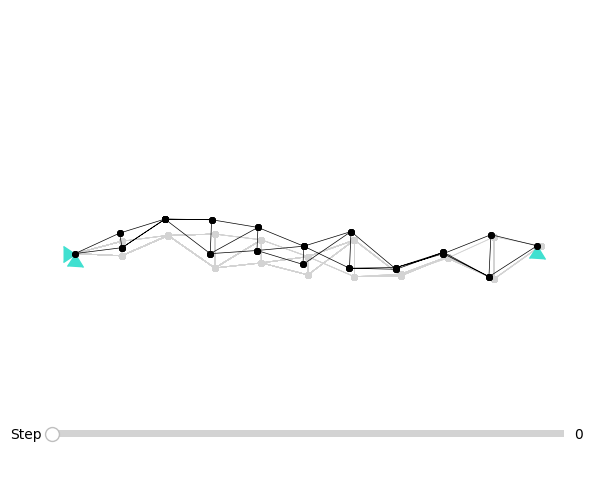

C:\Users\javie\AppData\Local\Temp\ipykernel_15244\3040842390.py:81: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.best_samples_ = self.best_samples_.append({"y": y_max, "ei": optimal_ei}, ignore_index=True)


(35,)
[[0.99951583]
 [0.99951583]] [[311.14324299 311.14324299]]
exp_imp shape: (2, 2)


ValueError: The user-provided objective function must return a scalar value.

In [8]:
optimizer = BayesianOptimizer(
    target_func= target_function_wrapper,
    x_init=x_init.T,
    y_init=y_init.real,
    n_iter=100,
    scale=1.0,  # Adjust based on expected variation in your design variables
    batch_size=1
)

optimal_design, max_frequency = optimizer.optimize()

###
Currently there is are some dimensionality issues with taking the different random samples